In [18]:
!pip install librosa
!pip install tensorflow
!pip install scikit-learn -U
!pip install adabelief-tf==0.2.0
!pip install keras-radam
!pip install keras-rectified-adam
!pip install keras-adabound

In [17]:
import IPython.display
import librosa
import librosa.display
import pandas as pd
import os
import struct
import glob
import soundfile as sf
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint 
from datetime import datetime
from sklearn import metrics 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from adabelief_tf import AdaBeliefOptimizer
from keras_radam.training import RAdamOptimizer
from keras_adabound import AdaBound
import tensorflow_addons
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
import pandas as pd
audiodata='/Users/dk20abk/OneDrive - University of Hertfordshire/Urbansound8k/Audio'
metadata_file_path='/Users/dk20abk/OneDrive - University of Hertfordshire/Urbansound8k/Metadata/UrbanSound8K.csv'
metadata=pd.read_csv('/Users/dk20abk/OneDrive - University of Hertfordshire/Urbansound8k/Metadata/UrbanSound8K.csv')
print("shape of the metadata =",metadata.shape)
metadata.head()

shape of the metadata = (8732, 8)


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [4]:
class_map = {'0' : 'air_conditioner', '1' : 'car_horn', '2' : 'children_playing', '3' : 'dog_bark', '4' : 'drilling', 
                 '5' : 'engine_idling', '6' : 'gun_shot', '7' : 'jackhammer', '8' : 'siren', '9' : 'street_music'}
pd.DataFrame(sorted(list(class_map.items())))

,0,1
0,0,air_conditioner
1,1,car_horn
2,2,children_playing
3,3,dog_bark
4,4,drilling
5,5,engine_idling
6,6,gun_shot
7,7,jackhammer
8,8,siren
9,9,street_music


In [5]:
# Extracting MFCC's For every audio file
max_pad_len=174
def feature_extraction(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    pad_width=max_pad_len - mfccs_features.shape[1]
    mfccs_scaled_features = np.pad(mfccs_features,pad_width=((0,0), (0,pad_width)),mode='constant')
    
    return mfccs_scaled_features

In [6]:
### iterate through every audio file and extract features using Mel-Frequency Cepstral Coefficients
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audiodata),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    final_class_labels=row["class"]
    data=feature_extraction(file_name)
    extracted_features.append([data,final_class_labels])

3555it [05:13,  9.89it/s]C:\Users\dk20abk\Anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1323
  return f(*args, **kwargs)
8324it [12:55, 15.08it/s]C:\Users\dk20abk\Anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1103
  return f(*args, **kwargs)
C:\Users\dk20abk\Anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1523
  return f(*args, **kwargs)
8732it [13:49, 10.52it/s]


In [7]:
# converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','final_class_labels'])
extracted_features_df.head(10)

,feature,final_class_labels
0,"[[-335.0899, -176.70966, -98.33869, -65.15997,...",dog_bark
1,"[[-492.1376, -455.06793, -449.95038, -444.2668...",children_playing
2,"[[-496.66345, -471.2096, -479.95898, -485.4825...",children_playing
3,"[[-447.43988, -412.1046, -408.45084, -408.2987...",children_playing
4,"[[-473.87814, -438.34927, -442.38864, -441.715...",children_playing
5,"[[-476.424, -455.1301, -453.6783, -449.24094, ...",children_playing
6,"[[-502.88834, -470.05255, -471.59225, -472.208...",children_playing
7,"[[-478.91837, -457.1805, -455.72546, -456.4423...",children_playing
8,"[[-530.94653, -497.3303, -497.20343, -499.4153...",children_playing
9,"[[-355.29086, -243.46605, -207.77112, -183.821...",car_horn


In [8]:
# # Split the dataset into independent and dependent dataset
x=np.array(extracted_features_df.feature.tolist())
y=np.array(extracted_features_df.final_class_labels.tolist())

In [9]:
# Label Encoder to get back the class name using inverse label encoder 
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
yy=to_categorical(labelencoder.fit_transform(y))
yy

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [10]:
# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(x, yy, test_size=0.2, random_state = 0)

In [11]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_train.shape)

(6985, 40, 174)
(6985, 10)
(1747, 40, 174)
(6985, 10)


In [12]:
num_rows = 40
num_columns = 174
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)
print(x_train.shape)

num_labels = yy.shape[1]
filter_size = 3

(6985, 40, 174, 1)


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras import datasets,models,layers
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from keras.models import Sequential
from keras.models import Model
import tensorflow as tf
# from keras.optimizers import SG

In [14]:
class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out
class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")
    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

In [20]:
k = []
ok = 0
yes = 0
zet = 0
yep = 0


opt =  [keras.optimizers.Adam(learning_rate=0.001),
                  keras.optimizers.SGD(learning_rate=0.01),
                  keras.optimizers.Nadam(learning_rate=0.001),
                  keras.optimizers.RMSprop(learning_rate=0.001),
                  AdaBeliefOptimizer(learning_rate=0.001),
                  RAdamOptimizer(learning_rate=0.001),
                  AdaBound(learning_rate=0.001, final_lr=0.1),
                  tensorflow_addons.optimizers.yogi.Yogi(learning_rate=0.001)]
for t in opt:
    del model
    if (t == opt[0]):
        print("------------------------optimizer = Adam--------------------------")
    elif (t == opt[1]):
            print("-------------------------optimizer = SGD-----------------------")
    elif (t == opt[2]):
            print("----------------------optimizer = Nadam------------------------")
    elif (t == opt[3]):
            print("----------------------optimizer = RMSprop----------------------")
    elif (t == opt[4]):
            print("-----------------------optimizer = AdaBelief-------------------")
    elif (t == opt[5]):
            print("-----------------------optimizer = RAdam-----------------------")

    elif (t == opt[6]):
            print("--------------------------optimizer = AdaBound-------------------")

    elif (t == opt[7]):
            print("-------------------optimizer = Yogi-------------------------------")
    model = ResNet18(10)
    model.build(input_shape = (None,40, 174, 1))
        
    
    #Compile model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer = t)


       # Fit the model
    k.append(model.fit(x_train, y_train, batch_size=256, epochs=20, validation_data=(x_test, y_test),verbose=1))


Please check your arguments if you have upgraded adabelief-tf from version 0.0.1.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  -------------
adabelief-tf=0.0.1       1e-08  Not supported      Not supported
Current version (0.1.0)  1e-14  supported          default: True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

------------------------optimizer = Adam--------------------------
Epoch 1/20
28/28 [==============================] - 274s 9s/step - loss: 1.4410 - accuracy: 0.5605 - val_loss: 418.4363 - val_accuracy: 0.1139
Epoch 2/20
28/28 [==============================] - 273s 10s/step - loss: 0.6329 - accuracy: 0.7865 - val_loss: 84.7841 - val_accuracy: 0.1139
Epoch 3/20
28/28 [==============================] - 294s 11s/step - loss: 0.4232 - accuracy: 0.8544 - val_loss: 17.5754 - val_accuracy: 0.1168
Epoch 4/20
28/28 [==

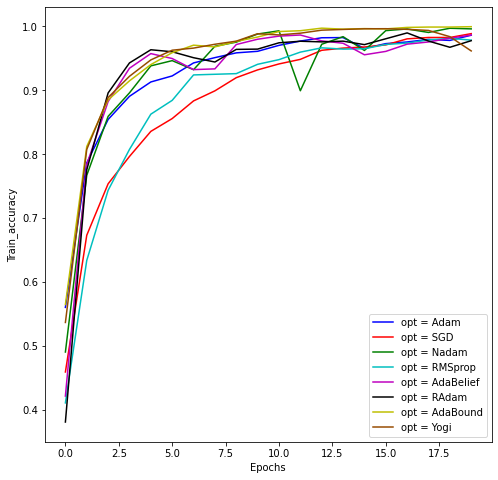

In [21]:
while (ok<len(k)):  
    
    
    plt.figure(figsize=(8,8))
    plt.plot(k[ok+0].history['accuracy'],color='b', label="opt = Adam")
    plt.plot(k[ok+1].history['accuracy'],color='r', label="opt = SGD")
    plt.plot(k[ok+2].history['accuracy'],color='g', label="opt = Nadam")
    plt.plot(k[ok+3].history['accuracy'],color='c', label="opt = RMSprop")
    plt.plot(k[ok+4].history['accuracy'],color='m', label="opt = AdaBelief")
    plt.plot(k[ok+5].history['accuracy'],color='k', label="opt = RAdam")
    plt.plot(k[ok+6].history['accuracy'],color='y', label="opt = AdaBound")
    plt.plot(k[ok+7].history['accuracy'],color='#964B00', label="opt = Yogi")
    
    plt.xlabel('Epochs')
    plt.ylabel('Train_accuracy')
    plt.legend()
    plt.show() 

    ok +=8


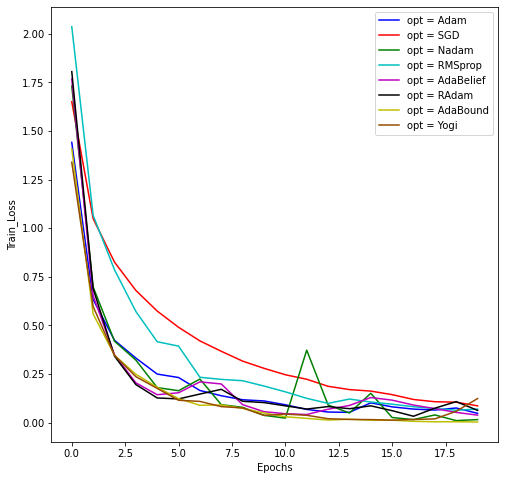

In [22]:
while (yes<len(k)):   



    plt.figure(figsize=(8,8))
    plt.plot(k[yes+0].history['loss'],color='b', label="opt = Adam")
    plt.plot(k[yes+1].history['loss'],color='r', label="opt = SGD")
    plt.plot(k[yes+2].history['loss'],color='g', label="opt = Nadam")
    plt.plot(k[yes+3].history['loss'],color='c', label="opt = RMSprop")
    plt.plot(k[yes+4].history['loss'],color='m', label="opt = AdaBelief")
    plt.plot(k[yes+5].history['loss'],color='k', label="opt = RAdam")
    plt.plot(k[yes+6].history['loss'],color='y', label="opt = AdaBound")
    plt.plot(k[yes+7].history['loss'],color='#964B00', label="opt = Yogi")
    
    plt.xlabel('Epochs')
    plt.ylabel('Train_Loss')
    plt.legend()
    plt.show() 

    yes+=8

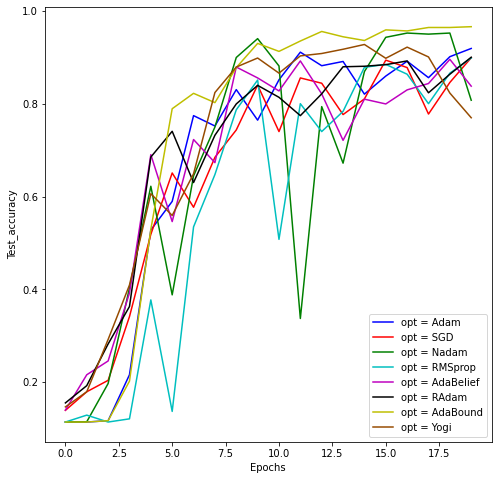

In [23]:
while (zet<len(k)):   



    plt.figure(figsize=(8,8))
    plt.plot(k[zet+0].history['val_accuracy'],color='b', label="opt = Adam")
    plt.plot(k[zet+1].history['val_accuracy'],color='r', label="opt = SGD")
    plt.plot(k[zet+2].history['val_accuracy'],color='g', label="opt = Nadam")
    plt.plot(k[zet+3].history['val_accuracy'],color='c', label="opt = RMSprop")
    plt.plot(k[zet+4].history['val_accuracy'],color='m', label="opt = AdaBelief")
    plt.plot(k[zet+5].history['val_accuracy'],color='k', label="opt = RAdam")
    plt.plot(k[zet+6].history['val_accuracy'],color='y', label="opt = AdaBound")
    plt.plot(k[zet+7].history['val_accuracy'],color='#964B00', label="opt = Yogi")
    
    plt.xlabel('Epochs')
    plt.ylabel('Test_accuracy')
    plt.legend()
    plt.show() 

    zet+=8

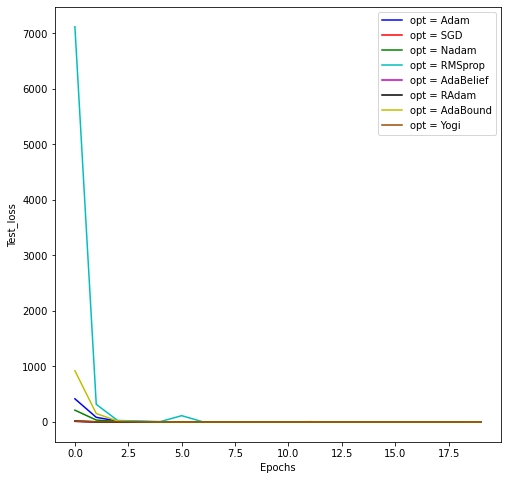

In [24]:
while (yep<len(k)):   



    plt.figure(figsize=(8,8))
    plt.plot(k[yep+0].history['val_loss'],color='b', label="opt = Adam")
    plt.plot(k[yep+1].history['val_loss'],color='r', label="opt = SGD")
    plt.plot(k[yep+2].history['val_loss'],color='g', label="opt = Nadam")
    plt.plot(k[yep+3].history['val_loss'],color='c', label="opt = RMSprop")
    plt.plot(k[yep+4].history['val_loss'],color='m', label="opt = AdaBelief")
    plt.plot(k[yep+5].history['val_loss'],color='k', label="opt = RAdam")
    plt.plot(k[yep+6].history['val_loss'],color='y', label="opt = AdaBound")
    plt.plot(k[yep+7].history['val_loss'],color='#964B00', label="opt = Yogi")
    
    plt.xlabel('Epochs')
    plt.ylabel('Test_loss')
    plt.legend()
    plt.show() 

    yep+=8

In [25]:
# # # Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])
duration = datetime.now() - start
print("Training completed in time: ", duration)

Training Accuracy:  0.8316392302513123
Testing Accuracy:  0.7698912620544434
Training completed in time:  6:42:49.523425


In [28]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [29]:
#Make predictions
y_probs = model.predict(x_test)

#Convert prediction probabilities into integers
y_preds = y_probs.argmax(axis=1)

55/55 [==============================] - 4s 73ms/step


In [30]:
y_test_cm = y_test.argmax(axis=1)
cm=confusion_matrix(y_preds,y_test_cm)

In [31]:
cm

array([[128,   0,   0,   0,   0,   7,   0,   0,   1,   1],
       [  0,  79,   1,   7,   1,   7,   3,   2,   7,   1],
       [  2,   2, 128,  13,   0,  11,   0,   0,  10,   1],
       [  0,   0,   3, 135,   0,   3,   4,   0,   5,   1],
       [ 31,   2,   7,  12, 190,  19,   4,   6,   7,   1],
       [  0,   0,   0,   0,   2, 129,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   4,  76,   0,   1,   0],
       [ 13,   3,   1,   1,   7,   4,   0, 177,   1,   4],
       [  0,   0,   0,   1,   0,   0,   0,   0, 129,   0],
       [ 21,   5,  65,  13,   2,  32,   0,   2,  38, 174]], dtype=int64)

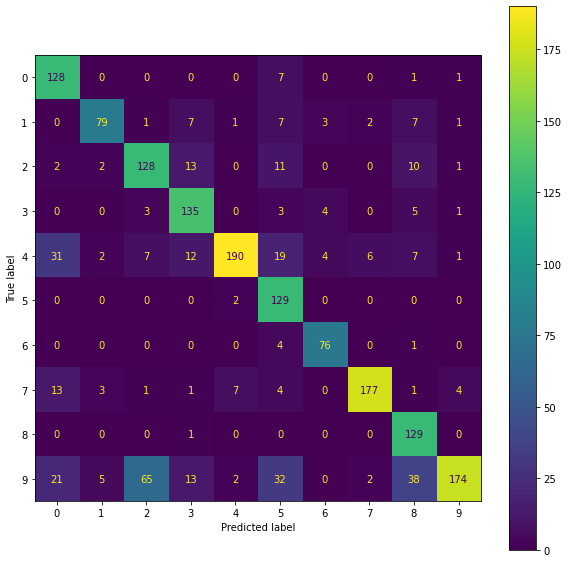

In [32]:
#Plot
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_map)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);

In [33]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_cm, y_preds)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test_cm, y_preds,average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_cm, y_preds,average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_cm, y_preds,average='macro')
print('F1 score: %f' % f1)

Accuracy: 0.769891
Precision: 0.825579
Recall: 0.784766
F1 score: 0.782644
